In [1]:
import pandas

from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
import plotly.offline as py
import plotly.graph_objs as go

import random
from scipy import signal

# Lecture 1: Noise in measurements

!!! success "Expected prior knowledge"

    Before the start of this lecture, you should be able to:

    - recall the definition of a Fourier transform 

!!! summary "Learning goals"

    After this lecture you will be able to:

    - estimate average quantities and their statistical error from noisy measurements
    - characterize noise via its power spectral density
    - identify common kinds of noise spectra
    

Consider the following problem. We have a small voltage that we want
to measure. We assume the voltage to be constant in time. To measure it, we connect the small voltage to an amplifier and then
connect our amplified signal to an oscilloscope that records the voltage at its
input as a function of time. 

![](figures/1/scope.PNG){: style="width:500px"}

On our oscilloscope screen, we see the following trace:

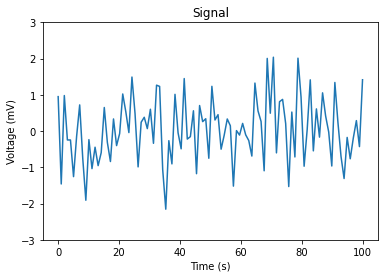

In [2]:
mu, sigma = 0, 1
ts = np.linspace(0,100,100)
vs = np.asarray([np.random.normal(mu,sigma) for t in ts])

plt.plot(ts, vs)
plt.title("Signal")
plt.xlabel("Time (s)")
plt.ylim(-3,3)
plt.ylabel("Voltage (mV)")
plt.show()

What is approximately the value of the voltage?
- the average of the trace seems to be about 0 mV
- How can we quantify how close it is to 0 mV?

A good first step: create a histogram of the data, which might look like

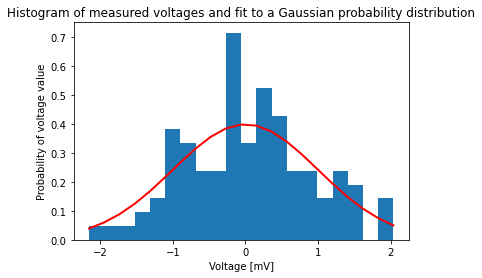

In [3]:
count, bins, ignored = plt.hist(vs, 20, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title("Histogram of measured voltages and fit to a Gaussian probability distribution")
plt.xlabel("Voltage [mV]")
plt.ylabel("Probability of voltage value")
plt.show()

(In this histogram, we have normalized the bin counts to match the Gaussian fit.)

Fitting to a Gaussian, we find a full-width half-maximum (FWHM) of 2 mV. We thus estimate that, on average, the statistical error in each measurement point is about $\pm 1$ mV.

However, because we assumed that the voltage we are trying to measure is constant in time, we can reduce the error in our estimate of the 
unknown small voltage by averaging points together. We know how to calculate the average, but what is the uncertainty in this average value? 

The error $\sigma_N$ of our average of $N$ points is related to the error $\sigma_1$ of a single point by 
$$
\sigma_N^2 = \frac{\sigma_1^2}{N}
$$
The quantity $\sigma_N$ is known as the standard error of the mean. How is this quantity related to our histogram above? Adding
more points will not change the *shape* of the distribution, it will only give 
more counts in each bin. 

The reduction of $\sigma_N$ with respect to $\sigma_1$, however, has nothing to do with the width of the histogram. Rather, it determines how accurately we can determine the center of the peak (the average): The more points we add, the smaller the (relative) statistical fluctuations in the height of each bin will become, and the more accurately we will be able to find the center of the peak.

**Caveat**: The above equation relating the standard error of the mean $\sigma_N$ to the standard error of a single measurement $\sigma_1$ is only true if the noise in your data is *uncorrelated*, which means that each data point in your trace represents an independent sampling of the random noise of your amplifier. 

How can one know if the noise is uncorrelated? By calculating its autocorrelation function. For a function $v(t)$ it is defined as
$$
R_{vv}(\tau) =  \langle v(t+\tau) v(t) \rangle
$$
where the angled brackets denote the expectation value/ensemble average. A common example of correlated noise arises when your signal has some "memory" that is slower than your sampling rate such that consecutive samples will have similar values.  For example, if you put a 1 kHz low-pass
filter after your amplifier, but configure your oscilloscope to record the signal
with a 10 kHz sampling rate, then $R_{vv}$ will look something like this:

[]

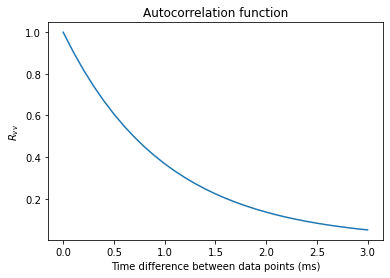

In [4]:
ts = np.linspace(0,3,31)
ys = np.exp(-ts)
plt.plot(ts, ys)
plt.title("Autocorrelation function")
plt.ylabel("$R_{vv}$")
plt.xlabel("Time difference between data points (ms)")
plt.plot()

In this example, we can see that each measured value displayed on our oscilloscope will be strongly correlated with several values in its direct neighborhood. In this case, the values are not independently drawn from the random distribution, and the error in our estimate of the average voltage will *not* scale with $\frac{1}{N}$ if we average $N$ such points

## Power Spectral Density

To summarize so far:

- The error in estimating the average of a noisy measurement depends on how many (uncorrelated) points we measure
- If we record a dataset of uncorrelated points for a time $T_m$, the error in our estimate of the mean value will go down as $\sigma_T^2 \propto \frac{1}{T_m}$

However, if we measure for longer periods of time, then our measurements are
slower. This becomes an issue if we want to measure a signal that is not constant in time, because increasing $T_m$ reduces
the speed at which we can record a changing signal.  Thus, there is a tradeoff
between the noise level $\sigma_v$ and the *bandwidth* of your measurement.

Question: if you want buy an amplifier, does it make sense to look at its noise level without looking at its bandwidth? Why (not)?

So then, how do we characterize noisy, time-varying signals? We can compute
the power spectral density $S_{xx}(\omega)$, which tells us how the "noise
power" is distributed across different frequencies.

For a signal $V(t)$, we first define a (finite-time, truncated) Fourier 
transform:
$$
\hat{V}(\omega) = \frac{1}{\sqrt{T}} \int_0^T V(t)e^{-i \omega t} dt
$$
where the prefactor $\frac{1}{\sqrt{T}}$ is for normalization.  The power
spectral density is then defined as the "ensemble average" of the magnitude
of $\hat{V}(\omega)$:
$$
S_{VV}(\omega) = \big \langle | \hat{V}(\omega) |^2 \big \rangle
$$

What do we mean by "ensemble average"?

- If the noise in our measurement is random, its Fourier transform is also 
random
- To reduce the "noise" in our estimate of the noise, we average over the 
$|\hat{V}(\omega)|^2$ of many different measurement traces

The power spectral density describes how the power in a signal is distributed over different frequencies. It is also called the power spectrum. 

How could we measure a power spectral density in practice?

![](figures/1/filter.PNG){: style="width:500px"}

Here, the bandpass filter transmits the part of the signal within a frequency band $\Delta \omega$ centered at $\omega_0$. The rectifier converts the transmitted signal into a DC voltage $V_\text{out}$. As a result, $V_\text{out}$ is proportional to the amount of power present in $v(t)$ in the frequency band $\omega_0\pm\Delta\omega/2$, given by $ V_{out}^2 = S_\text{vv}(\omega_0) {\Delta \omega} $

## Types of noise specta

### White noise
Uncorrelated noise is called 'white noise'. Its power spectral density is flat (independent of frequency)

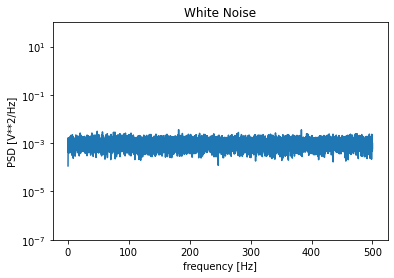

In [5]:
fs = 1e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = 0
# x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

f, Pxx_den = signal.welch(x, fs, nperseg=len(x)//4)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.title("White Noise")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

### 1/f noise
Common in many experiments, particularly for f < 100kHz

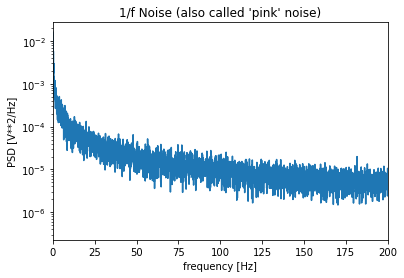

In [6]:
plt.semilogy(f[1:], Pxx_den[1:]/f[1:])
#plt.ylim([1e-7, 1e2])
plt.xlim([0,200])
plt.title("1/f Noise (also called 'pink' noise)")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

### "Peaked" noise

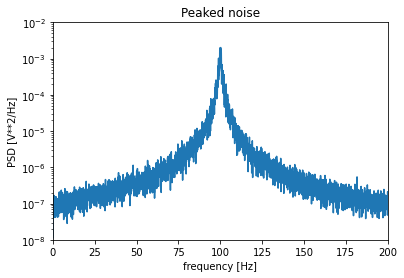

In [7]:
plt.semilogy(f, Pxx_den/(1+(f-100)**2))
plt.ylim([1e-8, 1e-2])
plt.xlim([0,200])
plt.title("Peaked noise")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

**Example**: Calculating the noise in a measurement from a known power spectral density

Suppose the spec sheet of our amplifier specifies $S_\text{vv}=1 \, \text{nV}^2/\text{Hz}$ within the amplifier bandwidth (0-1 MHz). We can then calculate the expected fluctuations $\sigma_v$ of the data points in a timetrace $V(t)$ that we would measure with an oscilloscope, using
$$
\sigma_v^2 = \int_{\omega_1}^{\omega_2} S_\text{vv}(\omega) d\omega
$$
What determines $\omega_1$ and $\omega_2$? If we measure for a total time $T_m$, we are insensitive to frequencies below $\omega_1 = 1/T_m$. Furthermore, $\omega_2$ is given by the upper limit of the bandwidth of our amplifier (1 MHz), assuming that our oscilloscope does not limit the measurement bandwidth. If $T_m= 1$ s, then 
$$
\begin{align}
\sigma_\text{v}^{2} &= \int_{1}^{10^6} \frac{1 \, \text{nV}^2}{\text{Hz}} df\\
&= 10^{-18} (10^6 - 1) \approx 10^{-12} \, \text{V}^2\\
\sigma_\text{v} &= 1 \, \mu\text{V}
\end{align}
$$
so the RMS noise on the measurement will be 1$\mu $V

What if we put a 1 kHZ low-pass filter on the output of our amplifier?

$$ 
\begin{align}
\sigma_\text{v}^{2} &= \int_{1}^{10^3} \frac{1 \, \text{nV}^2}{\text{Hz}} df \\
= & 10^{-15} \, \text{V}^2\\
\sigma_\text{v} &= 31 \, \text{nV}
\end{align}
$$

Conclusions:

- Measuring longer decreases the uncertainty in the average of the measured quantity according to $\sigma_N^2= \sigma_1^2/N $, provided the N data points are uncorrelated.
- The power spectral density $S_{xx}(\omega)$ is the Fourier transform of the autocorrelation function $R_{xx}(t)$:
$$
S_{xx}(\omega) = \int_{-\infty}^{+\infty} R_{xx}(t) e^{-i\omega t} dt
$$
- For uncorrelated noise, $R_{xx}(\tau) = \delta(\tau)$, such that $S_{xx}(\omega)$ is a constant (white noise)
- The expected noise in a data trace can be calculated by integrating over the power spectral density
